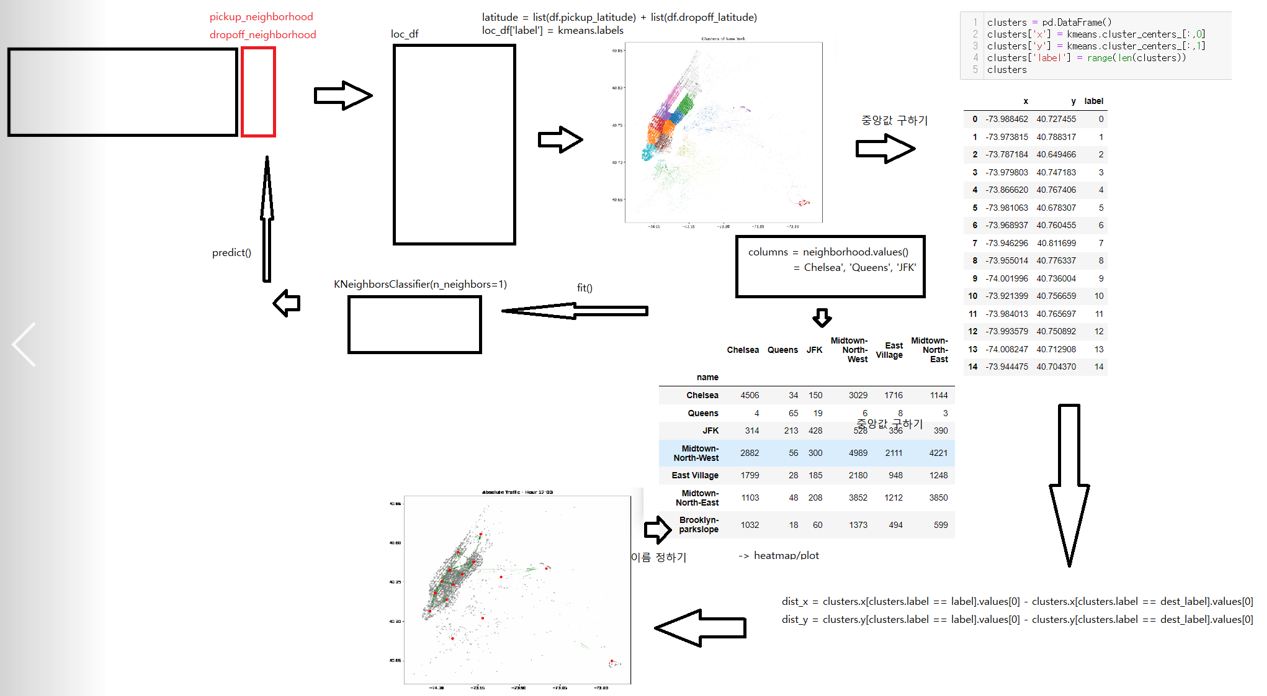

하루 동안 택시의 교통 상황은 어떻게 변합니까?

이 질문에 답하기 위해 저는 K-평균 클러스터링을 사용하여 뉴욕을 위치에 따라 다른 그룹으로 클러스터링하고 모든 클러스터로 들어오고 나가는 트래픽을 하루 중 시간의 함수로 분석합니다. 주거 지역은 저녁에 더 많은 트래픽이 유입되는 반면 상업 지역은 주로 낮에 사람들을 끌어들이고 야간 유흥이 풍부한 지역은 밤에 더 많은 트래픽을 보일 것으로 예상할 수 있습니다.

이것은 하루 중 다른 시간에 각 지역의 가능한 목적지를 알 수 있으므로 지속 시간 예측에 도움이 될 수 있습니다.


In [9]:
# !pip install -U imbalanced-learn

In [1]:
from imblearn.under_sampling import RandomUnderSampler

In [10]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm # colormap
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser # 파서 모듈은 더 많은 형식으로 날짜/시간 문자열을 구문 분석할 수 있습니다. Python에서 날짜와 시간을 구문 분석하는 데 dateutil보다 더 나은 라이브러리는 없습니다. 시간대를 조회하기 위해 tz 모듈은 모든 것을 제공합니다. 이러한 모듈이 결합되면 문자열을 시간대 인식 datetime objects.2019로 구문 분석하는 것이 매우 쉽습니다.

import io
import base64 # Base64 인코딩은 바이너리 또는 텍스트 데이터가 있는 바이트를 ASCII 문자로 변환하는 데 사용됩니다. 인코딩은 데이터가 텍스트 전용 시스템을 통해 전송되거나 처리될 때 데이터가 손상되는 것을 방지합니다.2020. 5. 26.
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output
#print(check_output(["ls", "./input/"]).decode("utf8"))

### Read the data

In [11]:
df = pd.read_csv('./input/train.csv')

In [12]:
df.head()  # (1438626, 14)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Remove rides to and from far away areas

In [13]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude> xlim[0]) & (df.pickup_longitude < xlim[1])] # -74.03 < pickup_longitude < -73.77
df = df[(df.dropoff_longitude> xlim[0]) & (df.dropoff_longitude < xlim[1])] # -74.03 < dropoff_longitude < -73.77
df = df[(df.pickup_latitude> ylim[0]) & (df.pickup_latitude < ylim[1])] # 40.63 < pickup_longitude < 40.85 
df = df[(df.dropoff_latitude> ylim[0]) & (df.dropoff_latitude < ylim[1])] # 40.63 < dropoff_longitude < 40.85 

### Plot rides

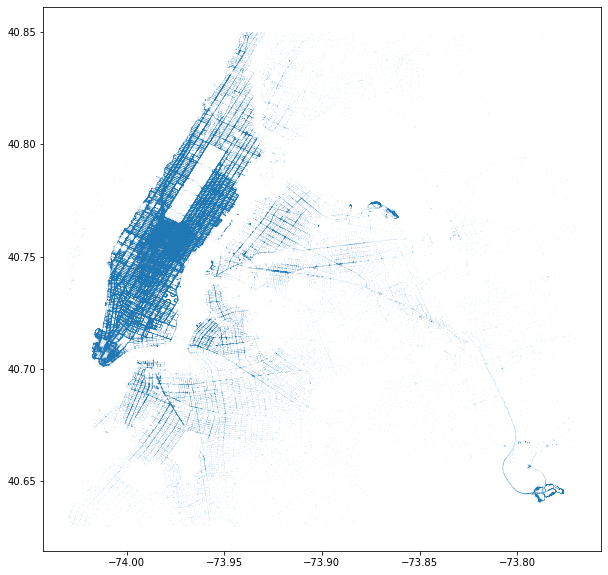

In [14]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude) # 2877252
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude) # 2877252
plt.figure(figsize = (10,10))
plt.plot(longitude, latitude, '.', alpha = 0.4, markersize = 0.05)
plt.show()

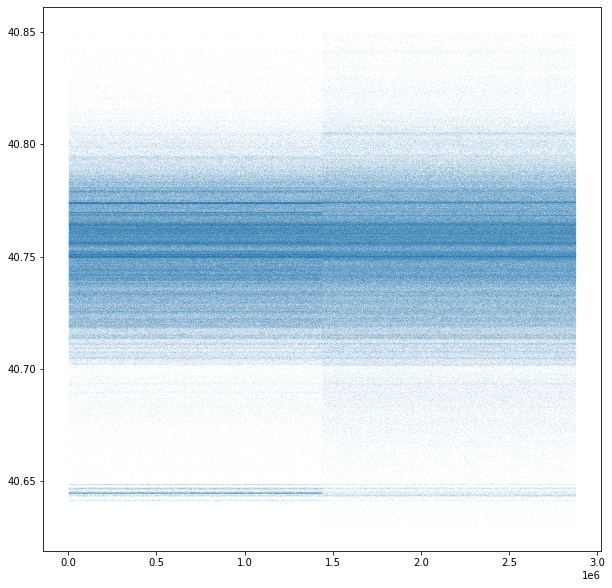

In [17]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude) # 2877252
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude) # 2877252
plt.figure(figsize = (10,10))
plt.plot(latitude, '.', alpha = 0.4, markersize = 0.05)
plt.show()

In [18]:
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
len(latitude)

2877252

In [19]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

### Cluster

Let's cluster New York City based on the pick-up and drop-off points of each taxi ride

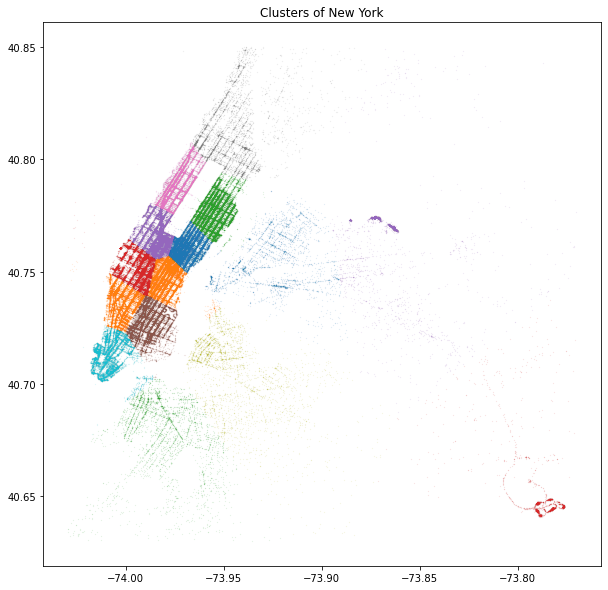

In [20]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_ # 0,1,2...14

loc_df = loc_df.sample(200000)
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

In [21]:
loc_df.label.unique()

array([ 6,  3,  8, 12, 11,  0,  1,  7, 14, 13, 10,  9,  5,  2,  4])

우리가 볼 수 있듯이 클러스터링은 NY가 다른 이웃으로 분할되는 방식과 다소 유사한 파티션을 생성합니다. 우리는 각각 회색과 분홍색으로 센트럴 파크의 어퍼 이스트와 웨스트를 볼 수 있습니다. 파란색은 웨스트 미드타운, 갈색은 첼시와 웨스트 빌리지, 파란색은 다운타운 지역, 보라색은 이스트 빌리지와 소호입니다.

JFK 및 La LaGuardia 공항에는 자체 클러스터가 있으며 Queens 및 Harlem도 있습니다. Brooklyn은 2개의 클러스터로 나뉘며, Bronx는 Harlem에서 분리하기에는 놀이기구가 너무 적습니다.
 
군집 중심을 플로팅해 보겠습니다.

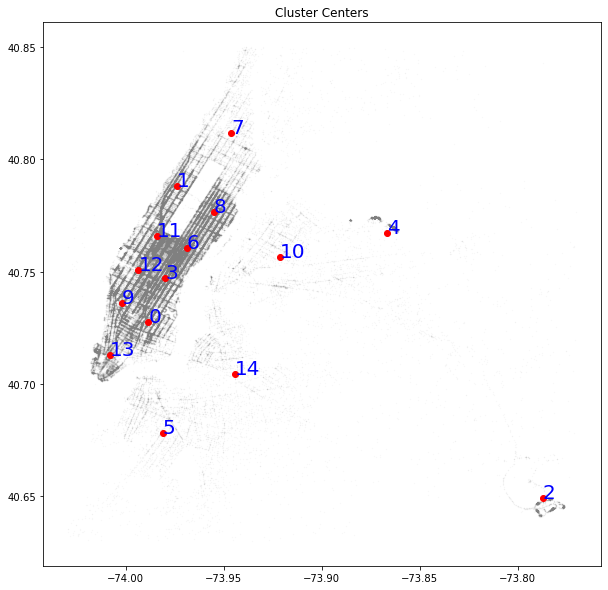

In [22]:
fig, ax = plt.subplots(figsize = (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0], kmeans.cluster_centers_[label,1], 'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

In [23]:
kmeans.cluster_centers_

array([[-73.98846204,  40.72745476],
       [-73.97381545,  40.7883167 ],
       [-73.78718399,  40.6494662 ],
       [-73.97980307,  40.74718301],
       [-73.8666204 ,  40.76740598],
       [-73.98106299,  40.67830747],
       [-73.96893692,  40.76045533],
       [-73.94629558,  40.81169885],
       [-73.95501392,  40.77633692],
       [-74.00199601,  40.73600375],
       [-73.92139937,  40.75665856],
       [-73.98401278,  40.76569673],
       [-73.99357934,  40.75089159],
       [-74.00824659,  40.71290811],
       [-73.94447511,  40.70436961]])

In [24]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour ) # 2016-03-14 17:24:55	

C:\Users\HOME\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- pickup_latitude
- pickup_longitude
Feature names seen at fit time, yet now missing:
- latitude
- longitude

  warnings.warn(message, FutureWarning)
C:\Users\HOME\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- dropoff_latitude
- dropoff_longitude
Feature names seen at fit time, yet now missing:
- latitude
- longitude

  warnings.warn(message, FutureWarning)


In [26]:
df[['pickup_longitude','pickup_latitude']]

,pickup_longitude,pickup_latitude
0,-73.982155,40.767937
1,-73.980415,40.738564
2,-73.979027,40.763939
3,-74.010040,40.719971
4,-73.973053,40.793209
...,...,...
1458639,-73.982201,40.745522
1458640,-74.000946,40.747379
1458641,-73.959129,40.768799
1458642,-73.982079,40.749062


In [25]:
df['pickup_cluster']

0          11
1           3
2          11
3          13
4           1
           ..
1458639     3
1458640    12
1458641     8
1458642     3
1458643     1
Name: pickup_cluster, Length: 1438626, dtype: int32

In [28]:
df['pickup_hour']

0          17
1           0
2          11
3          19
4          13
           ..
1458639    13
1458640     7
1458641     6
1458642    15
1458643    14
Name: pickup_hour, Length: 1438626, dtype: int64

In [30]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))
clusters

,x,y,label
0,-73.988462,40.727455,0
1,-73.973815,40.788317,1
2,-73.787184,40.649466,2
3,-73.979803,40.747183,3
4,-73.866620,40.767406,4
5,-73.981063,40.678307,5
6,-73.968937,40.760455,6
7,-73.946296,40.811699,7
8,-73.955014,40.776337,8
9,-74.001996,40.736004,9


In [31]:
loc_df = loc_df.sample(5000)

## Taxi rides from one cluster to another

그리고 다음 애니메이션에서 모든 화살표는 한 클러스터에서 다른 클러스터로의 이동을 나타냅니다. 화살표의 너비는 해당 시간의 상대적 이동량에 비례합니다.


In [36]:
num_of_rides = len(df[(df.pickup_cluster == 6) & (df.dropoff_cluster == 10) & (df.pickup_hour == 17)])
pct = np.true_divide(num_of_rides,len(df)) # num_of_rides/len(df)
num_of_rides

113

MovieWriter imagemagick unavailable; using Pillow instead.
C:\Users\HOME\AppData\Local\Temp/ipykernel_10268/2758010503.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,10));



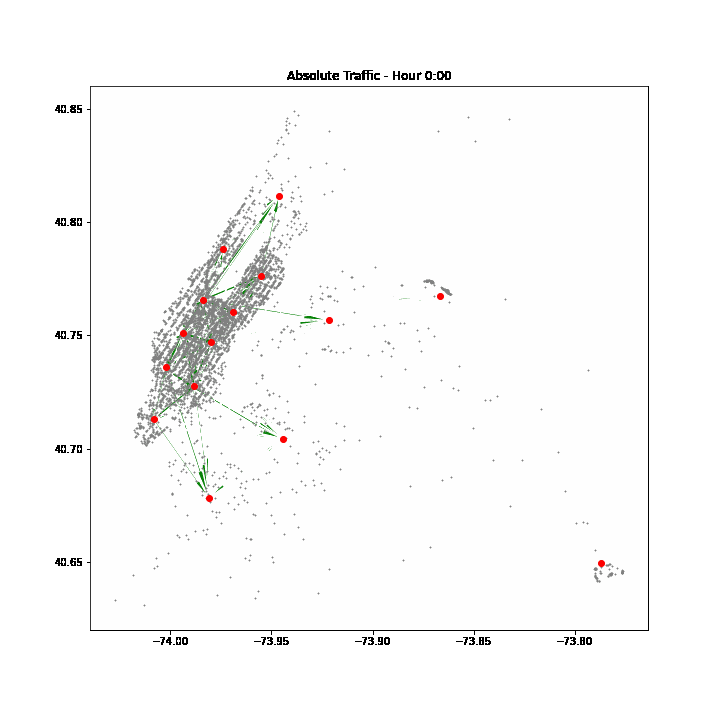

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Absolute Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10));
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray');
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r');


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            
            pct = np.true_divide(num_of_rides,len(df)) # num_of_rides/len(df)
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = 15*pct)
            ax.add_patch(arr) # 빈도화지에 그림넣기
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig, animate, sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()

ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

MovieWriter imagemagick unavailable; using Pillow instead.
C:\Users\HOME\AppData\Local\Temp/ipykernel_10268/2082614442.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,10))



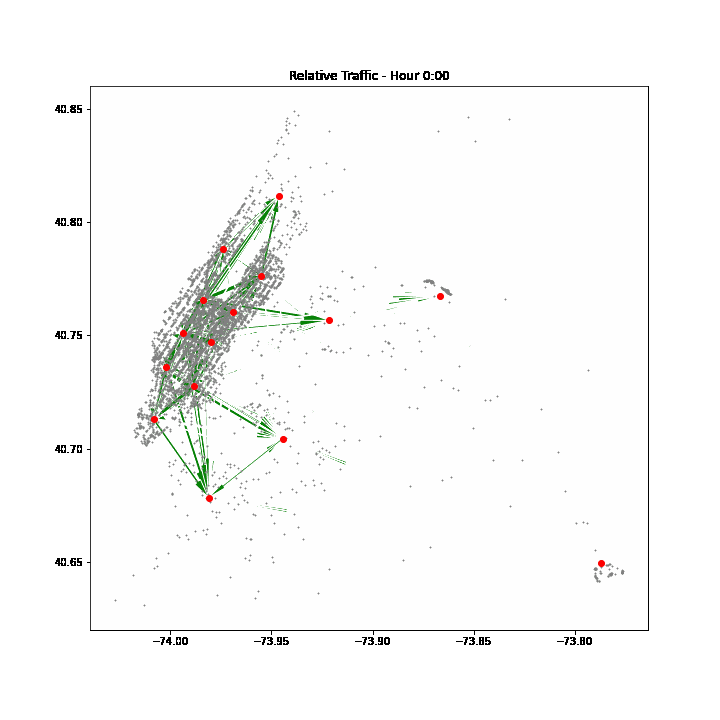

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()

ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

우리는 아침에 대부분의 교통량이 맨해튼섬에 있다는 것을 볼 수 있습니다.

브루클린 지역, 대부분 윌리엄스버그로 이동하는 택시의 비율은 늦은 저녁이 되면 훨씬 더 커집니다. 아침 시간대(반대 방향)에는 비슷한 움직임이 없기 때문에 출퇴근으로 인한 결과일 가능성은 낮습니다.  대신 22시 이후에는 대부분 교통이 혼잡하기 때문에 아마 외출하는 사람들일 겁니다.

화살표는 관련 시간의 상대적인 교통량을 나타내기 때문에, 브루클린으로 이어지는 화살표의 너비가 증가하는 것은 단지 그것의 큰 부분의 상업적인 특성 때문에 맨해튼의 놀이기구 감소의 결과일 수도 있습니다. 하지만 절대적인 교통량을 볼 때, 맨해튼에서 브루클린까지의 화살표는 하루의 대부분 동안 거의 보이지 않습니다.

아주 이른 아침, 두 공항을 오가는 교통량이 대부분입니다. 절대 그래프에서 알 수 있듯이, 이것은 단지 도시의 다른 지역의 교통량 감소의 결과입니다.

## Neighborhood Analysis

Le't manually assign the neighborhood name to each cluster


In [37]:
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-parkslope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',-73.9745967889:'Upper West Side'}

In [38]:
neighborhood.values()

dict_values(['Chelsea', 'Queens', 'JFK', 'Midtown-North-West', 'East Village', 'Midtown-North-East', 'Brooklyn-parkslope', 'LaGuardia', 'Midtown', 'Downtown', 'Queens-Astoria', 'Harlem', 'Uppe East Side', 'Brooklyn-Williamsburgt', 'Upper West Side'])

In [47]:
rides_df = pd.DataFrame(columns = neighborhood.values()) # Chelsea', 'Queens', 'JFK'
rides_df['name'] = neighborhood.values()

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))

KNeighborsClassifier(n_neighbors=1)

In [49]:
df['pickup_neighborhood'] = neigh.predict(np.array(df.pickup_longitude).reshape(-1,1))
df['dropoff_neighborhood'] = neigh.predict(np.array(df.dropoff_longitude).reshape(-1,1))

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))

In [62]:
rides_df

,Chelsea,Queens,JFK,Midtown-North-West,East Village,Midtown-North-East,Brooklyn-parkslope,LaGuardia,Midtown,Downtown,Queens-Astoria,Harlem,Uppe East Side,Brooklyn-Williamsburgt,Upper West Side
name,,,,,,,,,,,,,,,
Chelsea,4506,34,150,3029,1716,1144,984,201,5596,3358,356,324,1251,351,1387
Queens,4,65,19,6,8,3,0,17,6,6,5,2,7,4,7
JFK,314,213,428,528,356,390,105,230,531,245,345,178,518,206,333
Midtown-North-West,2882,56,300,4989,2111,4221,1110,564,5616,1459,478,760,3517,602,3757
East Village,1799,28,185,2180,948,1248,402,300,2647,912,268,285,1109,263,1459
Midtown-North-East,1103,48,208,3852,1212,3850,523,360,2471,701,418,1048,5878,801,3084
Brooklyn-parkslope,1032,18,60,1373,494,599,249,109,1302,483,182,177,615,179,767
LaGuardia,343,165,127,776,438,511,137,412,604,327,403,186,556,247,501
Midtown,6024,72,225,6650,2852,2855,1366,459,7065,3282,648,748,2655,702,3590


이제 히트맵을 구성하고 승객이 어디로 오고 가는지 살펴보겠습니다(이것은 모든 ride의 집계 값입니다).

In [52]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

trace = go.Heatmap(z= np.array(rides_df.values),
                  x = rides_df.columns[:-1], # ['Chelsea', 'Queens', 'JFK',...'Upper West Side']
                  y = rides_df.columns) # ['Chelsea', 'Queens', 'JFK',...'Upper West Side', 'name']

layout = dict(
    title = ' <b>Neighborhoods Interaction</b>',
    titlefont = dict(
    size = 30,
    color = ('rgb(100,100,100)')),
    margin = dict(t=100,r=100,b=100,l=150),
        yaxis = dict(
            title = ' <b> From </b>'),
        xaxis = dict(
            title = '<b> To </b>'))

data=[trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

In [18]:
# fig,ax = plt.subplots(figsize = (12,12))
# cax = ax.matshow(rides_df.drop('name',axis = 1),interpolation='nearest',cmap=cm.afmhot)
# cbar = fig.colorbar(cax)
# ax.grid('off')
# ax.set_xticks(range(len(rides_df)))
# ax.set_xticklabels(rides_df.name, rotation =90,fontsize = 15)
# ax.set_yticks(range(len(rides_df)))
# ax.set_yticklabels(rides_df.name,fontsize = 15)
# ax.set_xlabel('To', fontsize = 25)
# ax.set_ylabel('From', fontsize = 25)
# ax.set_title('Neighborhoods Interaction', y=1.35, fontsize = 30)

In [56]:
rides_df.index = rides_df.name
rides_df = rides_df.drop('name', axis = 1)

In [57]:
rides_df

,Chelsea,Queens,JFK,Midtown-North-West,East Village,Midtown-North-East,Brooklyn-parkslope,LaGuardia,Midtown,Downtown,Queens-Astoria,Harlem,Uppe East Side,Brooklyn-Williamsburgt,Upper West Side
name,,,,,,,,,,,,,,,
Chelsea,28526,228,950,18989,10622,7657,6141,1497,35963,22084,2119,2209,7998,2317,8742
Queens,27,375,93,55,37,20,5,120,33,24,43,15,43,15,41
JFK,1887,1221,2779,3578,2116,2351,743,1463,3207,1576,1749,993,2847,1244,2208
Midtown-North-West,17496,416,2183,30833,13214,27005,6747,4206,35307,10196,2940,4654,22343,3898,23537
East Village,10616,186,1168,13532,5619,8030,2622,2073,16225,5980,1625,1793,7099,1704,9138
Midtown-North-East,7069,331,1346,24433,7833,25085,3355,2757,15474,4846,2669,6776,37879,5258,19356
Brooklyn-parkslope,6225,116,439,8320,2907,4031,1612,802,8282,3397,1070,1026,3830,1108,4751
LaGuardia,2055,950,793,5189,2958,3550,949,2620,3938,2256,2497,1230,3509,1591,3582
Midtown,37829,474,1833,41685,17402,18089,8724,3174,43352,22124,4277,4532,17223,4826,22242


맨해튼 중심 지역이 택시로 가장 많이 붐비는 지역이며 어퍼 이스트 쪽이 선두임을 알 수 있습니다. 또한 가장 일반적인 타기는 클러스터 내에 있음을 알 수 있습니다(애니메이션에서는 볼 수 없음).

히트맵은 상당히 대칭적입니다. 즉, 드롭오프 또는 그 반대보다 픽업이 훨씬 더 많은 클러스터가 없습니다. 확대해 보겠습니다.

Text(0.5, 1.0, 'Inbound and Outbound rides for each cluster')

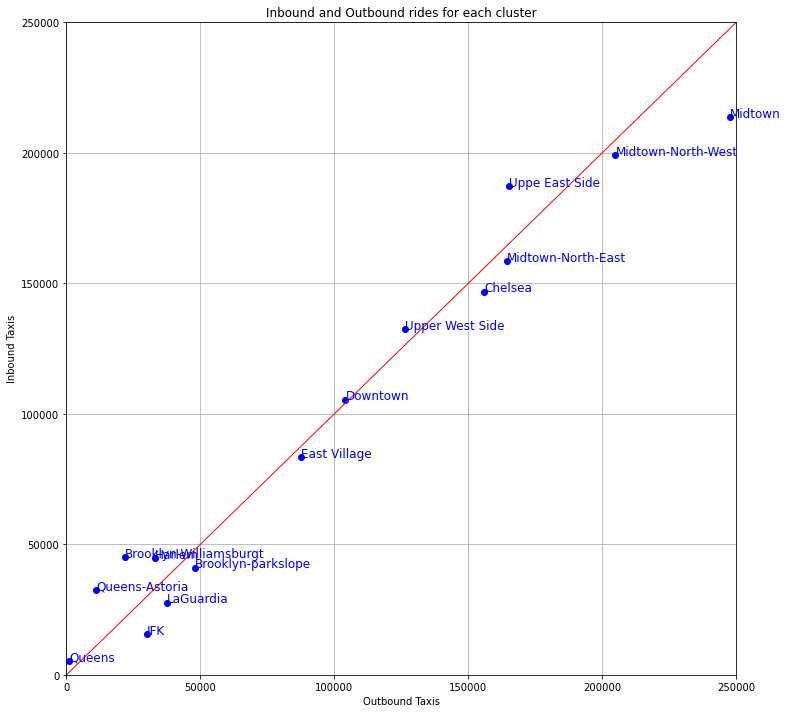

In [58]:
fig,ax = plt.subplots(figsize = (12,12))
for i in range(len(rides_df)):  
    ax.plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax.plot([0,250000],[0,250000], color = 'r', linewidth = 1) # linewidth : 선두께
ax.grid('off')
ax.set_xlim([0,250000])
ax.set_ylim([0,250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')

각 동네의 인바운드-아웃바운드 비율이 상대적으로 균형을 이루고 있음을 알 수 있습니다.

두 공항은 입국하는 공항보다 출국하는 공항이 더 많습니다. 이것은 말이 됩니다. 운전자들은 승객 없이 공항에 가서 사람들을 도시로 데려갈 기회를 가질 것입니다. 주거 지역 - Quuens, Brooklyn 및 Harlem은 인바운드 라이드가 더 많은 반면, 상업 및 관광 지역은 아웃바운드 라이드가 더 많습니다. 상업과 주거를 모두 갖춘 상동부와 서부는 거의 커브길에 있습니다.

사람들은 대체 교통수단으로 맨해튼으로 갈 것 같지만, 택시를 타고 그곳을 빠져나올 가능성이 더 높습니다.

## Winter vs Summer

In [59]:
df['pickup_month'] = df['pickup_datetime'].apply(lambda x: parser.parse(x).month )

In [61]:
df['pickup_month']

0          3
1          6
2          1
3          4
4          3
          ..
1458639    4
1458640    1
1458641    4
1458642    1
1458643    4
Name: pickup_month, Length: 1438626, dtype: int64

C:\Users\HOME\AppData\Local\Temp/ipykernel_10268/2359855918.py:11: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\HOME\AppData\Local\Temp/ipykernel_10268/2359855918.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



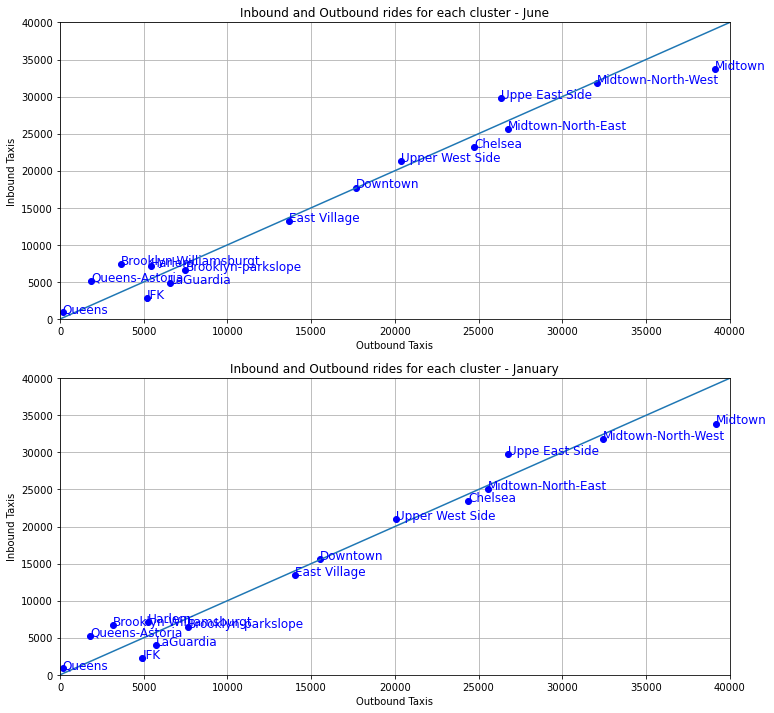

In [60]:
fig, ax = plt.subplots(2, figsize = (12,12))

rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()
rides_df.index = rides_df.name 

# 6월달
for col in rides_df.columns[:-1]: # ['Chelsea', 'Queens', 'JFK',...'Upper West Side']
    rides_df[col] = rides_df['name'].apply(lambda x: len(df[(df['pickup_neighborhood'] == x) & (df['dropoff_neighborhood'] == col) & (df['pickup_month'] == 6)]))

rides_df# 상관계수 형태

for i in range(len(rides_df)):  # 15
    ax[0].plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax[0].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[0].grid('off')
ax[0].set_xlabel('Outbound Taxis')
ax[0].set_ylabel('Inbound Taxis')
ax[0].set_title('Inbound and Outbound rides for each cluster - June')
ax[0].set_xlim([0,40000])
ax[0].set_ylim([0,40000])
ax[0].plot([0,40000],[0,40000])

# 1월달
for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 1)]))
rides_df = rides_df.drop('name', axis = 1)
for i in range(len(rides_df)):  
    ax[1].plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax[1].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[1].grid('off')
ax[1].set_xlabel('Outbound Taxis')
ax[1].set_ylabel('Inbound Taxis')
ax[1].set_title('Inbound and Outbound rides for each cluster - January')
ax[1].set_xlim([0,40000])
ax[1].set_ylim([0,40000])
ax[1].plot([0,40000],[0,40000])

우리가 볼 수 있듯이, 패턴은 월에 상관없이 거의 동일합니다. 눈 오는 1월 대 습하고 관광적인 6월은 매우 유사한 택시 패턴을 만듭니다.
